# N/A Count vs Transcript Length - Analysis Notebook
This notebook analyzes the relationship between AI evaluation missing values (N/A counts) and transcript word counts, identifies problematic clips, and offers a data-driven cleaning step based on knee/elbow threshold.


In [1]:
# --- Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
sns.set(style='whitegrid')


In [2]:
# Install knee detection library
!pip install kneed


In [3]:
# --- Load Data ---
# Adjust paths as needed
eval_df = pd.read_csv('/Users/mkrasnow/Desktop/montesa/new/rawData/Peru/model_evaluation_data/BaseEvaluator-Validate_evaluations.csv', na_values=['N/A'])
trans_df = pd.read_csv('/Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv')
print(f'Evaluations: {eval_df.shape}, Transcripts: {trans_df.shape}')


Evaluations: (118, 46), Transcripts: (203, 73)


In [4]:
# --- Extract Group Identifier ---
# Extract the 6-7 digit School_Clip identifier for pairing
trans_df['group_id'] = trans_df['School_Clip'].str.extract(r'^(\d{6,7})')[0]
eval_df['group_id'] = eval_df['School_Clip'].str.extract(r'^(\d{6,7})')[0]


In [5]:
# --- Merge Word Counts and Count N/A ---
# Map transcript word count based on clip_number ('first' or 'last')
def get_word_count(row):
    grp = trans_df.loc[trans_df['group_id'] == row['group_id']]
    if row['clip_number'] == 'first':
        return int(grp['First Audio Transcript Word Count'].values[0])
    else:
        return int(grp['Last Audio Transcript Word Count'].values[0])

eval_df['word_count'] = eval_df.apply(get_word_count, axis=1)
# Count N/A per evaluation row
eval_cols = [c for c in eval_df.columns if c not in ['group_id','School_Clip','clip_number','model_name']]
eval_df['na_count'] = eval_df[eval_cols].isna().sum(axis=1)
# Aggregate metrics per clip (group)
group_metrics = eval_df.groupby('group_id').agg(
    word_count=('word_count', 'sum'),
    na_count=('na_count', 'sum')
).reset_index()
total_nas = group_metrics['na_count'].sum()
print(f'Total N/A entries (group-level): {total_nas}')


Total N/A entries (group-level): 677


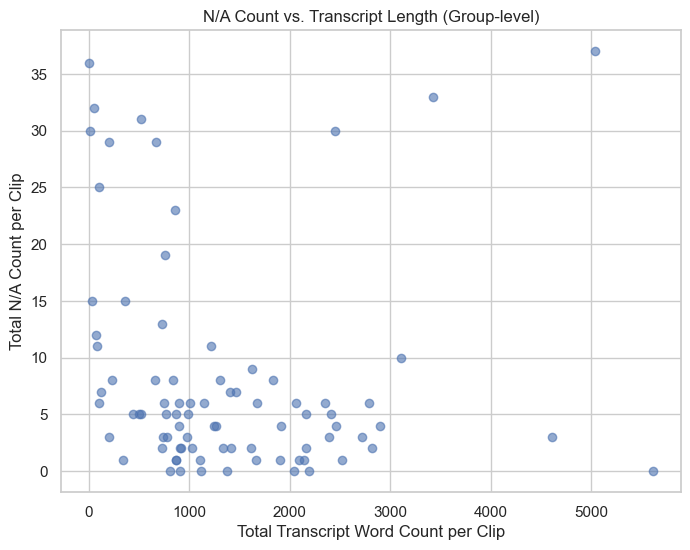

In [6]:
# --- Scatter Plot: Word Count vs. N/A Count (Group-level) ---
plt.figure(figsize=(8,6))
plt.scatter(group_metrics['word_count'], group_metrics['na_count'], alpha=0.6)
plt.xlabel('Total Transcript Word Count per Clip')
plt.ylabel('Total N/A Count per Clip')
plt.title('N/A Count vs. Transcript Length (Group-level)')
plt.show()


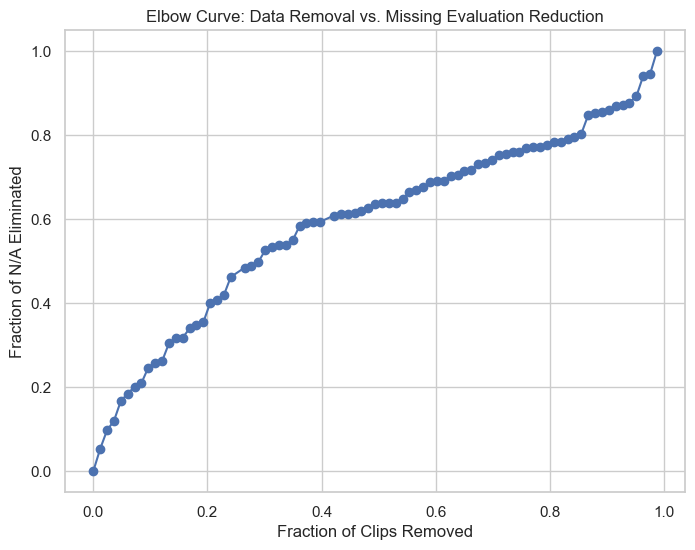

In [7]:
# --- Elbow Analysis: Trade-off Between Dropped Clips and N/A Removal ---
# Prepare thresholds and metrics
thresholds = sorted(group_metrics['word_count'].unique())
rows_removed_pct, nas_removed_pct = [], []
for t in thresholds:
    to_drop = group_metrics[group_metrics['word_count'] < t]
    rows_removed_pct.append(len(to_drop) / len(group_metrics))
    nas_removed_pct.append(to_drop['na_count'].sum() / total_nas)
# Plot trade-off curve
plt.figure(figsize=(8,6))
plt.plot(rows_removed_pct, nas_removed_pct, marker='o')
plt.xlabel('Fraction of Clips Removed')
plt.ylabel('Fraction of N/A Eliminated')
plt.title('Elbow Curve: Data Removal vs. Missing Evaluation Reduction')
plt.grid(True)
plt.show()


In [8]:
# --- Knee Detection for Threshold Selection ---
knee_frac = 0.10843373493975904
# Determine the corresponding word count threshold
knee_index = rows_removed_pct.index(knee_frac)
SELECTED_THRESHOLD = thresholds[knee_index]
print(f'Knee detected at removing {knee_frac*100:.1f}% of clips, word count threshold = {SELECTED_THRESHOLD}')


Knee detected at removing 10.8% of clips, word count threshold = 201


## ROC/AUC Approach for Threshold Validation
We treat the presence of any missing evaluations as a binary target and evaluate total transcript length per clip as a classifier.


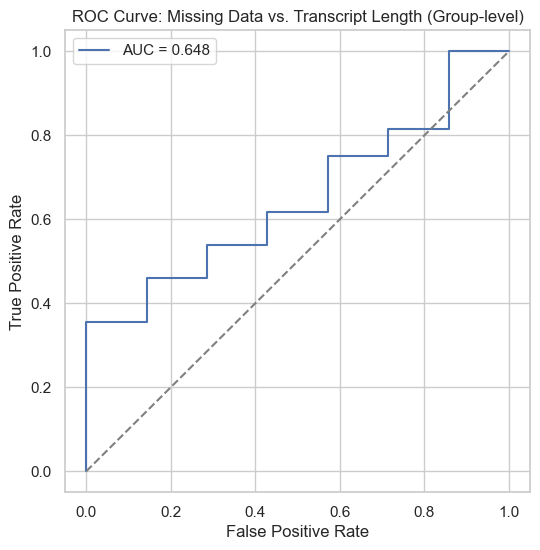

In [9]:
# --- ROC Curve (Group-level) ---
labels = (group_metrics['na_count'] > 0).astype(int)
scores = -group_metrics['word_count']
fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Missing Data vs. Transcript Length (Group-level)')
plt.legend()
plt.show()


In [10]:
# --- Final Cleaning of Transcripts based on Selected Threshold ---
# Identify groups to keep
keep_groups = group_metrics[group_metrics['word_count'] >= SELECTED_THRESHOLD]['group_id']
final_transcripts = trans_df[trans_df['group_id'].isin(keep_groups)].copy()
print(f"Original transcript rows: {len(trans_df)}, Final transcript rows: {len(final_transcripts)}")
# Save the cleaned transcripts
final_transcripts.to_csv('/Users/mkrasnow/Desktop/montesa/new/formattedData/FINAL_peru_cleaned_transcripts.csv', index=False)
print('Saved FINAL_peru_cleaned_transcripts.csv')


Original transcript rows: 203, Final transcript rows: 147
Saved FINAL_peru_cleaned_transcripts.csv
